# ENAE450 Final Report
##### Team 11: Bryan Houlton, Rohan Uttamsingh

All code referenced here as well as the project files, documentation, and demos are [here](https://gitlab.com/rohanuttamsingh/enae450final).

### Table of Contents
1. Background
2. Robotics Realization Lab
3. Simulation and Gazebo Setup
4. Conceptual Explaination of Algorithm
5. Naive Implementation
6. Improved Implementation
7. Expanded Implementation
8. Final Implementation

In [1]:
from IPython.display import Image

### Background
The problem presented in this project was as follows.
> Build a robot that can solve a maze, without knowledge of the whole maze.

To do this, we needed a couple areas of expertise.
1. General understanding of robotics engineering.
2. Programming in ROS.
3. Knowledge of maze solving algorithms.

We already had the first two and were initially exposed to the maze solving algorithms previously in the course, but had never attempted to solve a maze _with limited information_. To do this, we learned more about limited information maze solving and selected our algorithm.

### Robotics Realization Lab

In the Robotics Realization Lab, we focused on ensuring that we were able to connect and operate the robot. We began by following the intructions to connect to a Turtlebot3 Burger robot, and then verified the connection by teleoperating the robot. From here, we began visualizing the LiDAR data in RViz as we moved the Burger robot around in order to get a better idea of how we could use this data in our algorithm.

If we had more access to the Lab, we would have liked to test our algorithms in the physical maze. While Gazebo provides a great way to quickly test what we have been working on, there are important differences between the real world and a simulation. For instance, the real world has more variables that could interact with the performance of the maze-solver, such as the wear on different parts of the robot, the different materials of the floor and walls of the maze, and the remaining battery of the robot.

### Simulation and Gazebo Setup
To test our algorithms in the Gazebo simulator, we created a world file with each of the three provided maze models, and a corresponding launch file for each world. From here, we were easily able to run our algorithm in any maze.

### Conceptual Explaination of Algorithm
Here the very basics of the algorithm. If you are in a maze and can't see anything from above, you have very limited information. You're best bet is just to try every possible path and see where it leads. An easy way to do this is to put your right hand on the right wall, and walk forward. Whatever you do, your hand stays on the wall. This ensures that you "follow" the right wall. If the maze has no "wall islands", then the maze walls form one big connected shape. Following the wall ensures that you go every possible place on the shape's perimeter, which ensures that you will exit.

### Naive Wall Follower
Our first implementation of this wall following algorithm was pretty good, but had notable issues. I'll walk you through the approach and then talk about the issues.

First, we needed to know when one (or both) of these things happened:
1. There's an opening to our right, aka by stepping forward, our hand would no longer be on the wall.
2. Theres a wall in front of us, so we need to turn to the left to keep our hand on the wall.

So, we used the robot's LIDAR sensor to detect both of these things. We used static thresholds to detect whether something was in front or to the right, and used single data points from the LIDAR. Here are the LIDAR arc ranges used to detect each side.

In [ ]:
arc_range_front = (0, 1)
arc_range_left = (90, 91)
arc_range_right = (270, 271)

For the thresholds, we determined that there was nothing to the right is the detected object was further away than the right threshold, and the front was the same.

In [ ]:
threshold_right = 1
threshold_front = 1

There were some problems with this approach. Mainly, it would get caught on corners. Here's an example.

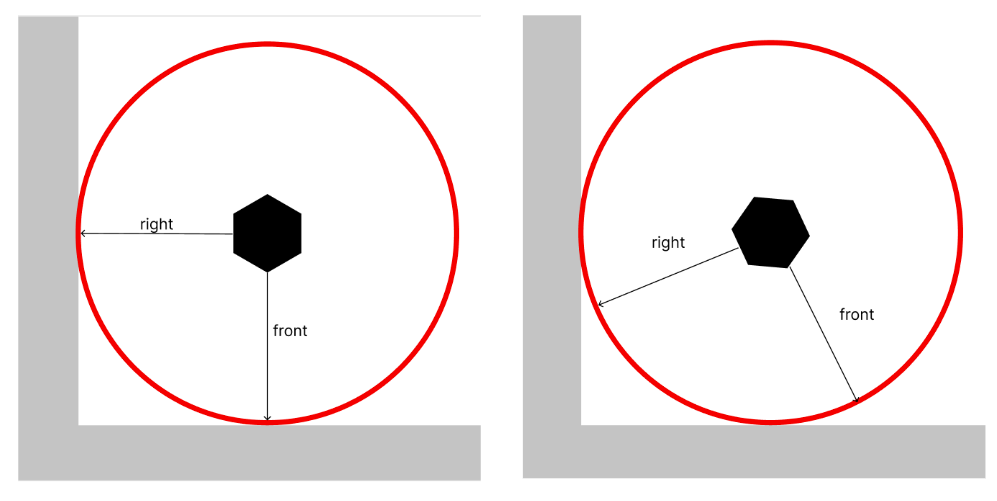

In [2]:
Image('Capture2.png')

In the left image, the robot has been "following" the right wall but has just detected something in front of it. This triggers the left turn. The robot turns left slightly (image is exaggerated), but the problem is that it no longer sees the right wall! The right wall is no longer inside the threshold after it starts to turn left. So, it triggers the rule of "there is nothing to the right, turn right", and starts turning right. Then, we're back to where we started and the process repeats.

Something similar also happens with 180 degree turns, where the thresholds will be triggered, the turn is started, then because the robot turned, the thresholds are no longer triggered. So, we tried to improve this.

### Improved Wall Follower
In order to improve the wall follower, we began tweaking some of the thresholds and parameters. To start, we separated the front and right thresholds into two different variables so that we could have greater control. This allowed us to keep the robot closer to the right wall while keeping it a safe distance away from the front.

Additionally, we introduced two different states to the robot – the initial state and the following state. Because the robot may not initially be placed with a wall to its right, but our algorithm relies on this, we had it move forward and while turning slightly right until it detected a wall in front of it in the initial state. From here, the robot would turn left until the wall was on its right, allowing it to begin the rest of the algorithm with a wall on its right. Then, in the following state, it would execute the same algorithm as before with the updated thresholds.

### Wall Separation Anxiety
Our final implementation addressed all of these problems and more. In fact, this implementation has been designed to self-correct itself so that there are minimal edge cases. At the simplest level, this algorithm builds off of the idea of the previous iterations: keep close to the wall, but not too close.

When doing this with thresholds we often find edge cases where the algorithm will fail. Corners, edges, and 180 degree turns are all cruxes of the previous algorithms. So, instead, we can define a dynamic threshold. We do this with the following piecewise function.

$$ y = \frac{\sqrt{2x} - 0.8}{5} \{y < 0\} $$
$$ y = \frac{3(x - 0.32)}{10} \{y > 0\} $$

For reference, this is what the graph looks like.

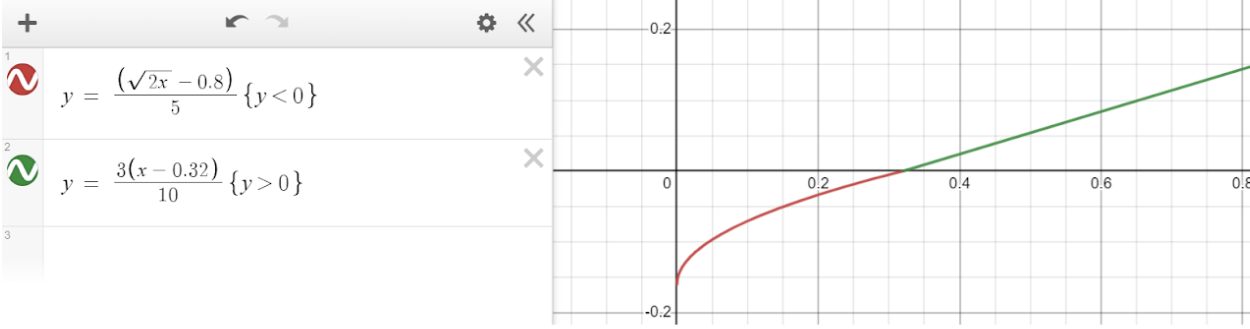

In [3]:
Image('Capture.png')

The X axis here is the distance from the wall on the right, and the Y axis is the turning speed (positive is clockwise). What this does is that it pushes the robot away from the wall if it is too close, but keeps it close when it gets too far.

When the robot gets too close to the wall, it turns left. This is defined by a threshold in front of the robot. If the wall is too close, the robot will continue to turn left. Because of this, we have to define the positive function as a quadratic, so that when the robot has to go around big turns it can make those fast enough. If it doesn't make those turns fast enough, the front will detect a wall and start turning to the left, instead of continuing the right turn.

The code for this is broken up into a couple parts.

In [ ]:
def f(x):
    """
    Function to use for the self-stabilizing mechanism. This is just the above piece-wise function in code.
    """
    if x < 0.3:
        return (sqrt(x) - sqrt(0.4)) / 3
    return min((x ** 2 - 0.2 ** 2) / 3, 0.3)

We also have to define a callback function to set the robots movements. This callback is called when we get new data from the LIDAR sensor, and the data is passed in as the parameter `msg`.

In [ ]:
def cb(msg):
    """
    Callback for setting the command velocities.
    """
    
    # Get the variables used for turning and driving speeds.
    global turning, forward
    
    # Get wall distances in each direction.
    front, right, left = get_dirs(msg)

    # If we detect a wall close enough, inch forward while turning to the left.
    if front < 0.35:
        forward = 0.02
        turning = 0.5
        return

    # Turn based on the piecewise function we defined earlier. We have to invert it here though,
    # because ROS uses a +Z axis, so positive is counterclockwise instead of the clockwise we use
    # in our graph.
    turning = -f(right) * 3
    
    # Go forward while turning too, but slow down if turning so that we can make those tight turns!
    forward = 0.1 * (0.1 if right > 0.6 else 3)

This approach to the wall following algorithm solves basically every issue we've been having up to this point.

### Improved Wall Separation Anxiety

Wall Separation Anxiety was so close to working with only one minor catch. When the robot was far from the right wall, it would not turn right fast enough to correct its course. To alleviate this issue, we replaced the linear portion of the piecewise function from Wall Separation Anxiety with a quadratic.

This is the updated function:

$$ y = \frac{\sqrt{x} - \sqrt{0.4}}{3} \{y < 0\} $$
$$ y = \frac{x^2 - 0.2^2}{3} \{y > 0\} $$

Now, the further the robot is away from the right wall, the faster it will turn right. A visualization of this function can be seen below.

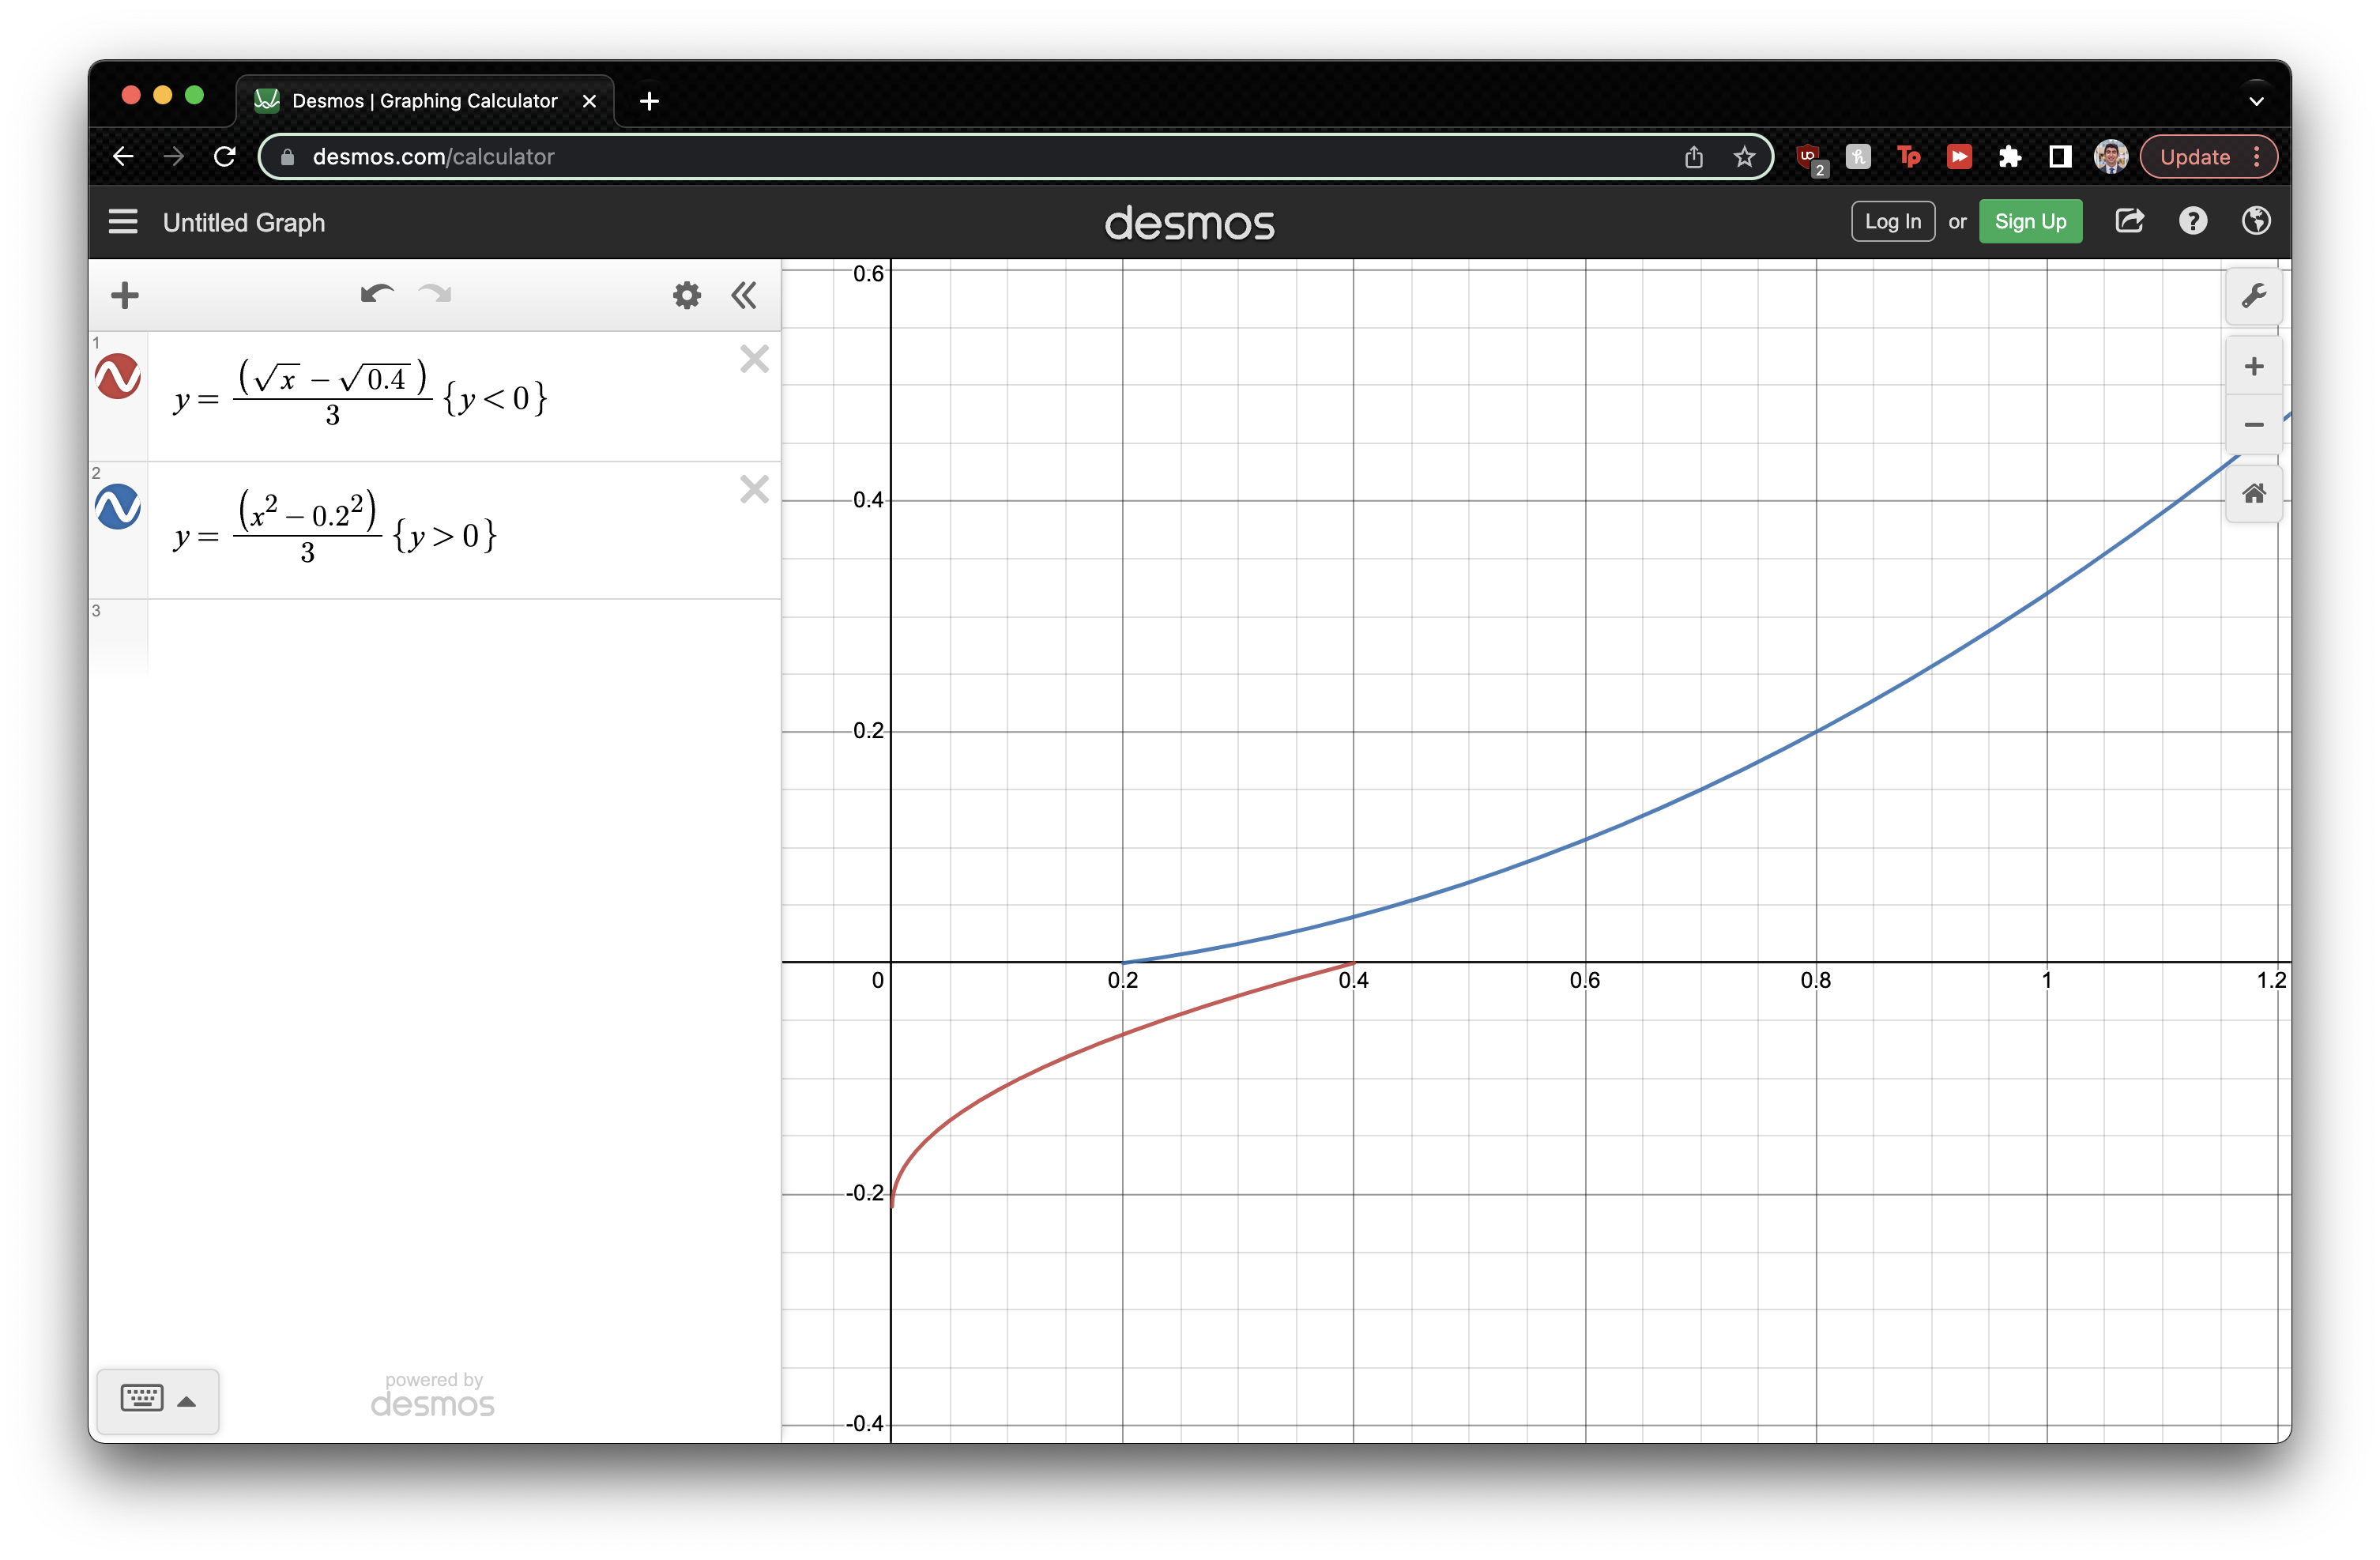

In [4]:
Image('quad.png')

In addition, although the piecewise condition changes when the distance from the right wall is 0.3, we do not have either part of the piecewise function be 0 at $x = 0$. This is so that there is no distance from the right wall where the robot would drive completely straight. This ensures that the robot is continuously correcting its course and minimizes the room for error.

Further, the right-turning portion of the piecewise function (the quadratic) is set to be no more than 0.3 in order to ensure that the robot does not turn too fast and overshoot when it approaches a sharp turn, such as the $180^\circ$ turns from mazes 1 and 2.

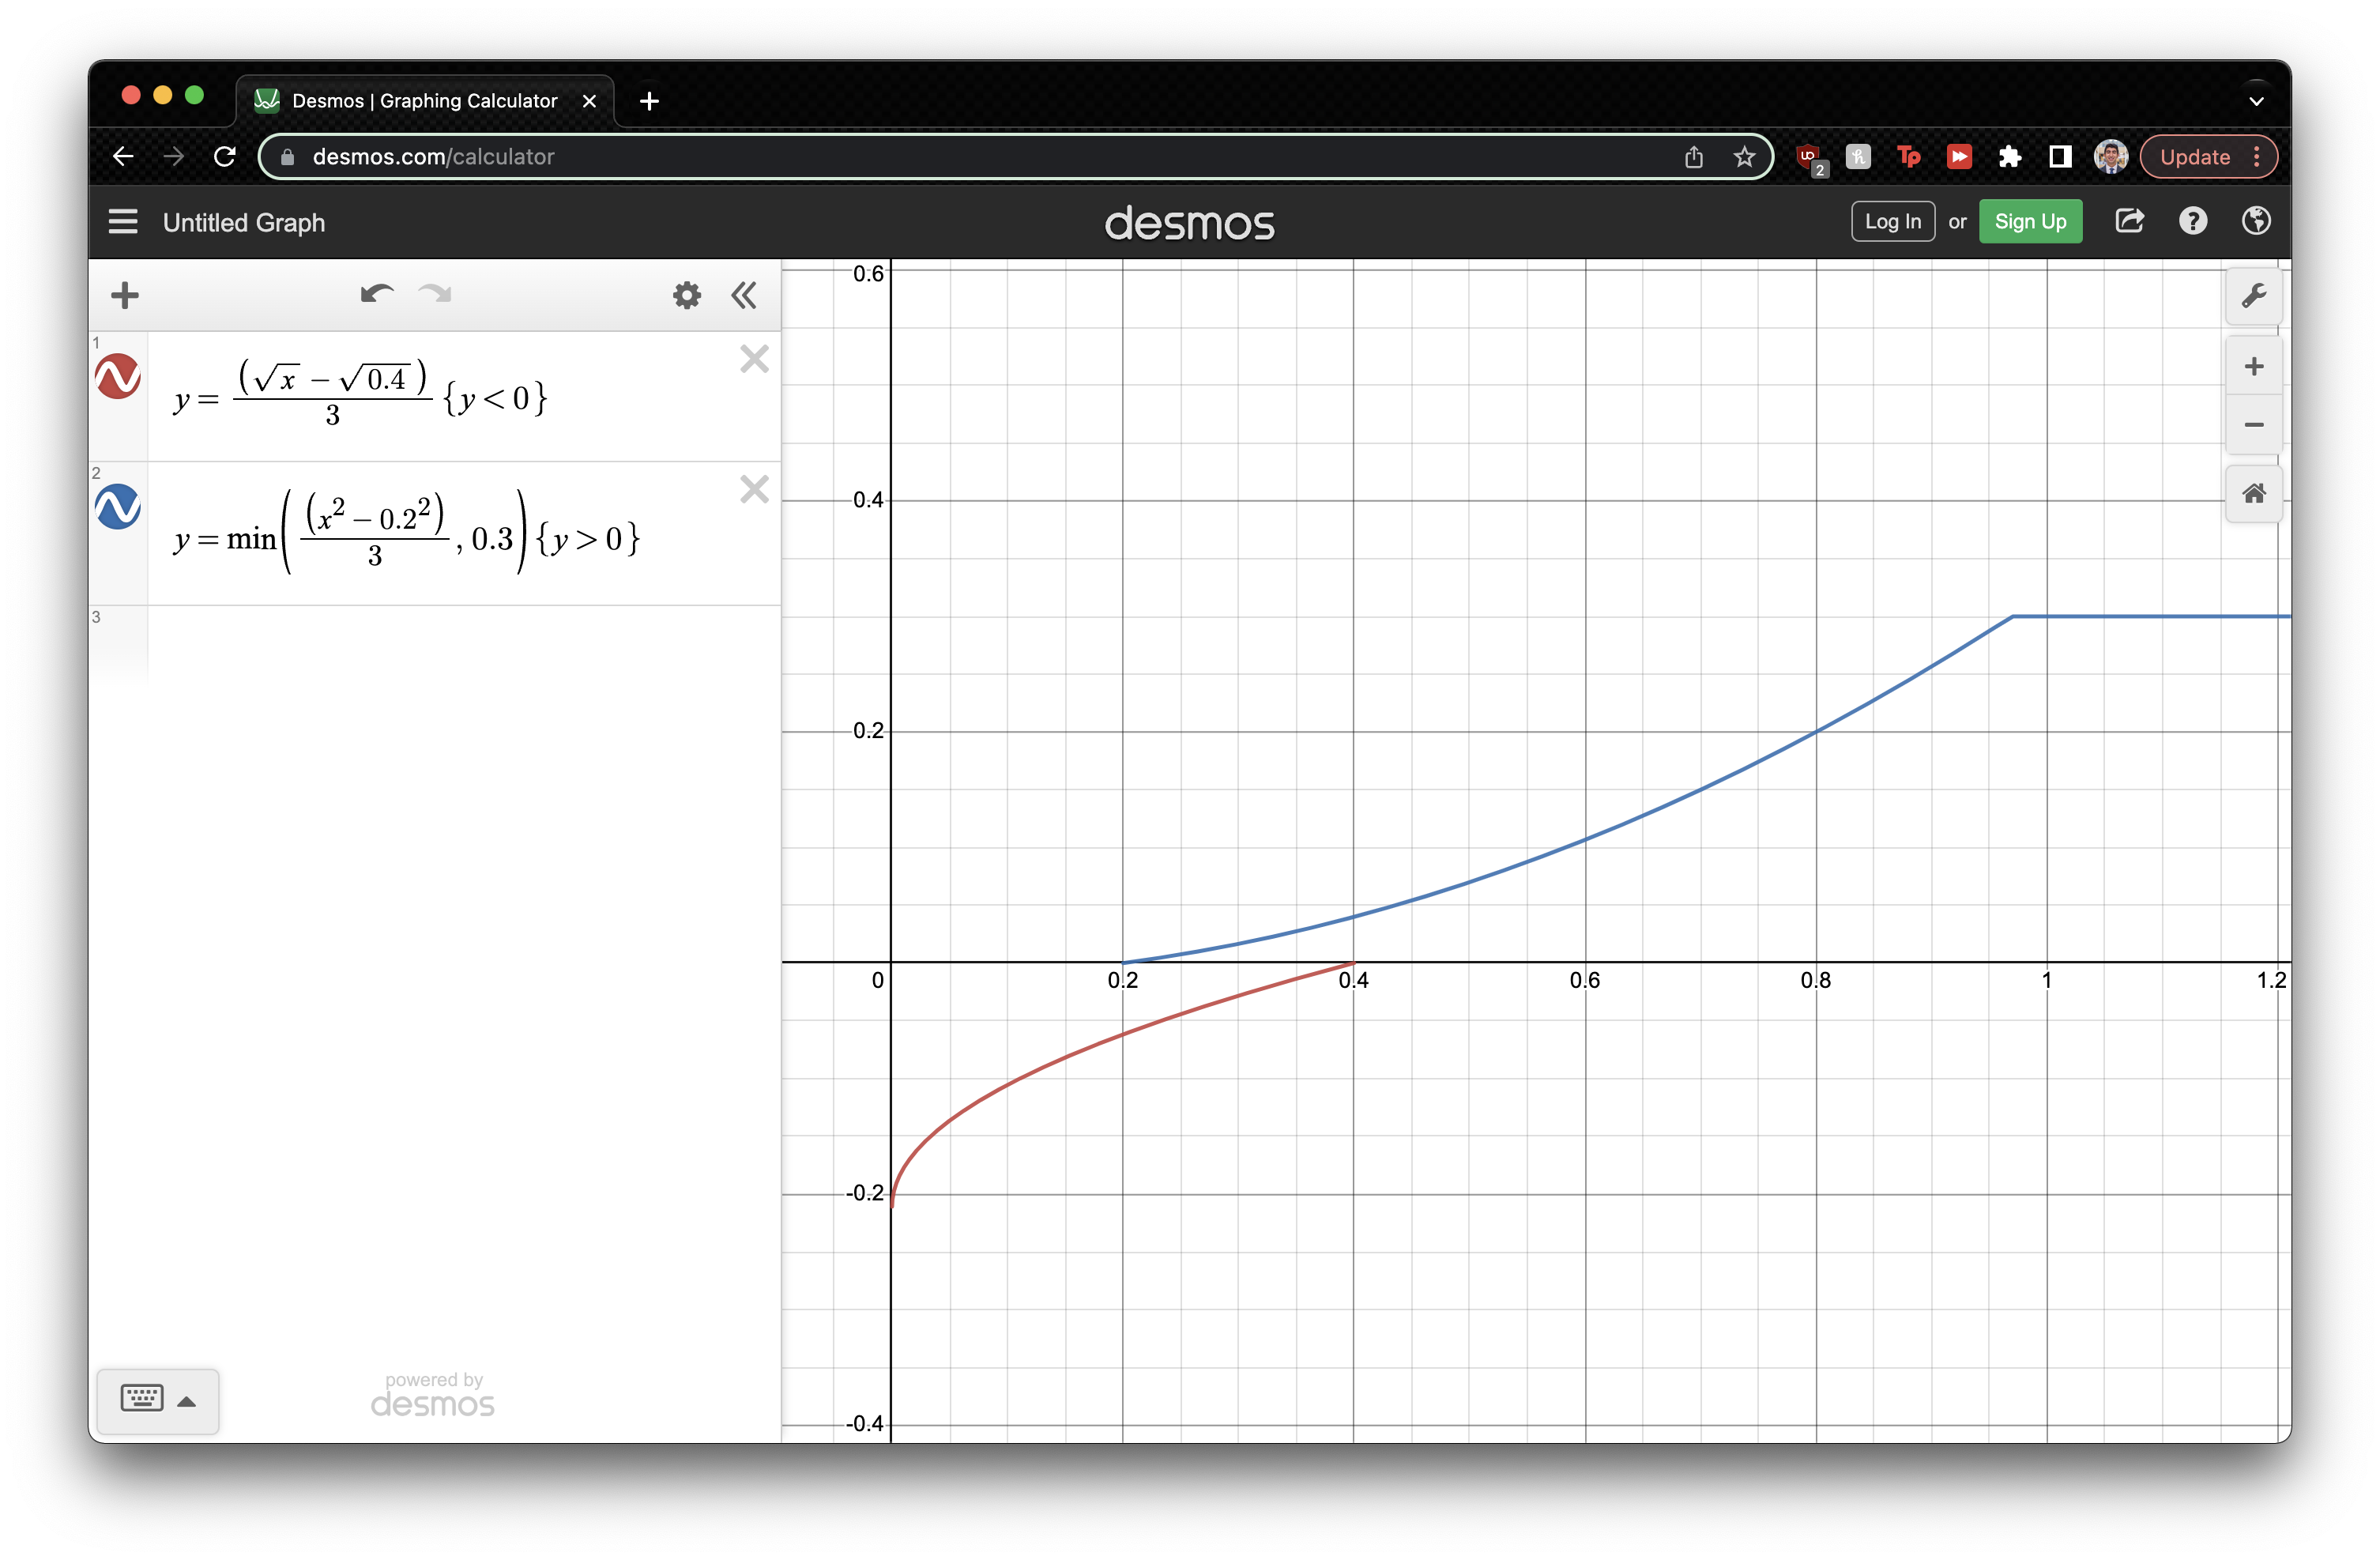

In [5]:
Image('minquad.png')

The code for this function is shown here:

In [ ]:
def f(x):
    if x < 0.3:
        return (sqrt(x) - sqrt(0.4)) / 3
    return min((x ** 2 - 0.2 ** 2) / 3, 0.3)

Mazes 1 and 2 included $180^\circ$ turns. An example is shown here.

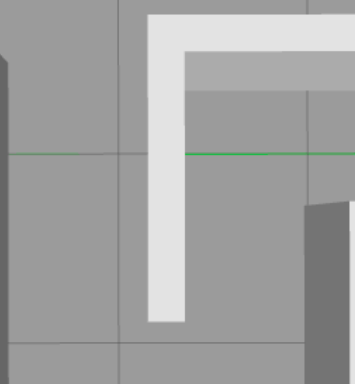

In [6]:
Image('180turn.png')

These turns were a challenge because of the robot's tendency to spiral out of control when it got to these. Three changes helped fix this problem

1. The forward velocity of the robot when there is not a wall in front of it is set to a constant 0.25. Before, this was variable based on the robot's distance from the right. This allowed the robot to move forward quickly enough to prevent the right turn from overshooting.

In [ ]:
forward = 0.25

2. The range of indices in the LiDAR readings used for the front and the right were modified. The front was expanded to be centered and wider, and the right was changed to include more of the range from the front-right of the robot and less from the back-right. Since the robot is moving forwards, this range is more indicative of the obstacles around the robot.

In [ ]:
arc_range_front = (-5, 5)
arc_range_right = (268, 275)

if front < 0.35:
    forward = 0.02
    turning = 0.53. The criteria to turn left and the speed at which the robot would turn left were modified. Now, the robot would only turn left if there is a wall within a range of 0.35 in front of it, rather than 0.4 from before. This is important because the robot's $180^\circ$ turns are often wide, and having that range be too large would cause the robot to turn left when it should have been turning right. Additionally, the robot would now move forward twice as fast while turning left, at a speed of 0.02 instead of 0.01. This helped prevent the robot from spinning in left circles by forcing it to continuously move forward.

In [ ]:
if front < 0.35:
    forward = 0.02
    turning = 0.5

Also just out of interest for completion, here is the code for our main function. However, you can find all code used [here](https://gitlab.com/rohanuttamsingh/enae450final).

In [ ]:
def main():
    rospy.init_node('reading_laser')
    pub = rospy.Publisher('/cmd_vel', Twist, queue_size=1)
    sub = rospy.Subscriber('/scan', LaserScan, cb)
    
    rate = rospy.Rate(20)
    while not rospy.is_shutdown():
        msg = Twist()
        msg.linear.x = forward
        msg.angular.z = turning
        pub.publish(msg)
        rate.sleep()

if __name__ == '__main__':
    main()

### Instructions to Run This Code

In a shell:

```
source devel/setup.bash
roslaunch maze_solver [launchfile]
```

where `launchfile` is the desired launch file. To launch one of the provided mazes, use `maze0.launch`, `maze1.launch`, or `maze2.launch`.

In a separate shell:

```
source devel/setup.bash
rosrun maze_solver follow_wall.py
```

The robot should now begin solving the maze.